In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
from pathlib import Path
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

In [2]:
def plot_values(nef_data, x='rev', block_type=None, cor_loc=None, cor_let=None, sharey=False, window_size=5):
    plot_df = nef_data.copy()
    
    # 1. Basic block_type filtering
    if block_type is not None:
        plot_df = plot_df[plot_df['block_type'] == block_type]

    # 2. Reversal Filter: Finds blocks where the RULE switched
    def get_switching_blocks(df, column, initial_rule):
        opposing_map = {'left': 'right', 'right': 'left', 'A': 'B', 'B': 'A'}
        target_rule = opposing_map.get(initial_rule)
        block_groups = df.groupby(['monkey', 'session', 'block'])
        valid_blocks = []
        for name, group in block_groups:
            rules_before = group[group['rev'] < 0][column].unique()
            rules_after = group[group['rev'] >= 0][column].unique()
            if (initial_rule in rules_before) and (target_rule in rules_after):
                valid_blocks.append(name)
        return valid_blocks

    if cor_loc is not None:
        valid_indices = get_switching_blocks(plot_df, 'cor_loc', cor_loc)
        plot_df = plot_df[plot_df.set_index(['monkey', 'session', 'block']).index.isin(valid_indices)]

    if cor_let is not None:
        valid_indices = get_switching_blocks(plot_df, 'cor_let', cor_let)
        plot_df = plot_df[plot_df.set_index(['monkey', 'session', 'block']).index.isin(valid_indices)]

    if plot_df.empty:
        print("No blocks found where the rule switched as specified.")
        return

    # 3. Smoothing Logic (applied per phase to avoid blurring the reversal)
    plot_df['after_rev'] = plot_df['rev'] >= 0
    all_cols = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar', 'acc','tdec']
    for col in all_cols:
        plot_df[col] = plot_df.groupby(['monkey', 'session', 'block', 'after_rev'])[col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    # --- Plotting Code ---
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(14, 4), sharex=True, sharey=sharey)
    titles = ['Values', 'Weights', 'Actions', 'Outcomes', 'RTs']
    columns = [['va', 'vb', 'vl', 'vr'], ['w'], ['al', 'ar'], ['acc'], ['tdec']]
    
    for i, cols in enumerate(columns):
        for j, col in enumerate(cols):
            sns.lineplot(data=plot_df, x=x, y=col, ax=axes[i], label=col)
        axes[i].set_title(titles[i])
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i].set(xlim=[-45,45])

    filter_info = [f"{k}={v}" for k, v in zip(['Type', 'CorLoc', 'CorLet'], [block_type, cor_loc, cor_let]) if v]
    fig.suptitle(f"Model Performance {' (' + ', '.join(filter_info) + ')' if filter_info else ''}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_performance(nef_data, window_size=5):
    emp = pd.read_pickle("data/empirical.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    # Apply smoothing to both dataframes,we group by monkey and block_type so the window doesn't blur different conditions together
    for dataset, target_col in [(emp, 'monkey_accuracy'), (nef_data, 'acc')]:
            # Create a temporary indicator: True if trial is after reversal, We use rev >= 0 (or > 0 depending on your task definition of the first reversal trial)
            dataset['after_rev'] = dataset['rev'] >= 0
            # Now we group by all identifiers PLUS the 'after_rev' flag
            dataset['smoothed_acc'] = dataset.groupby(['monkey', 'block_type', 'session', 'block', 'after_rev'])[target_col].transform(
                lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', ax=axes[0], palette=palette[:2],
                 hue='block_type', style='monkey', hue_order=['what', 'where'], style_order=['V', 'W'])
    axes[0].set_title('Empirical Data')
    axes[0].set(xlim=[-45,45], xlabel='Trial', ylabel='Accuracy')
    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', ax=axes[1], palette=palette[:2],
                 hue='block_type', style='monkey', hue_order=['what', 'where'], style_order=['V', 'W'])
    axes[1].set_title('NEF Model')
    axes[1].set(xlabel='Trial')
    plt.tight_layout()
    plt.show()

In [4]:
def load_nef(folder_path="data/nef/"):
    path = Path(folder_path)
    files = list(path.glob("*.pkl"))
    if not files:
        print(f"No .pkl files found in {folder_path}")
        return pd.DataFrame()
    df_list = [pd.read_pickle(f) for f in files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [5]:
def adjust_df(df):
    df['acc'] = df['acc'].replace(-1, 0)
    df['block_type'] = np.where(df['block'] <= 12, 'what', 'where')
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

In [6]:
nef_data = load_nef()
nef_data = adjust_df(nef_data)

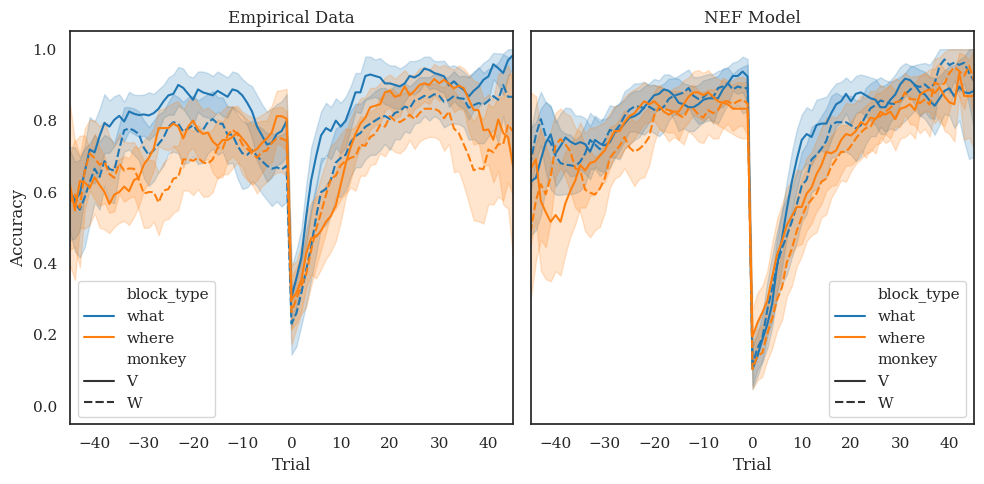

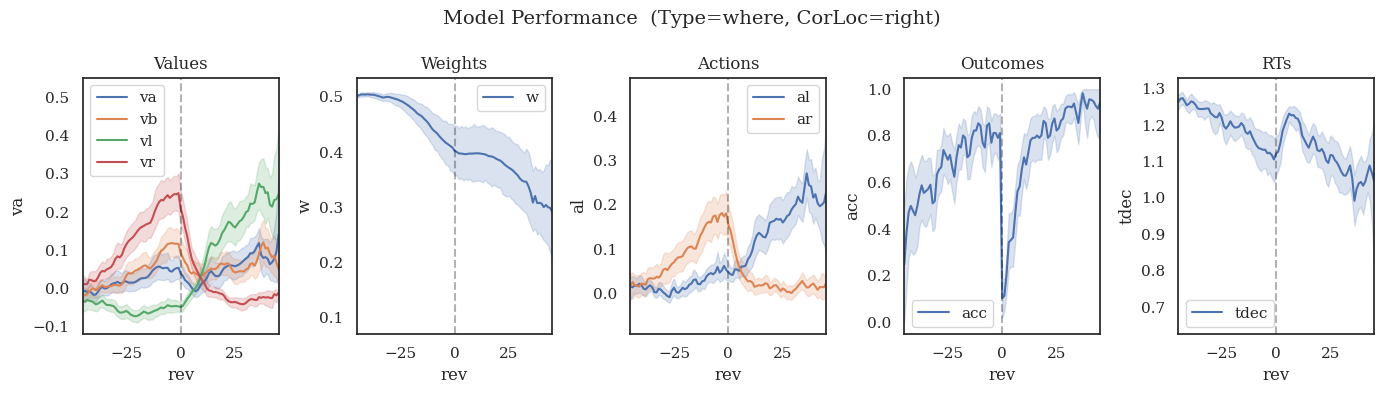

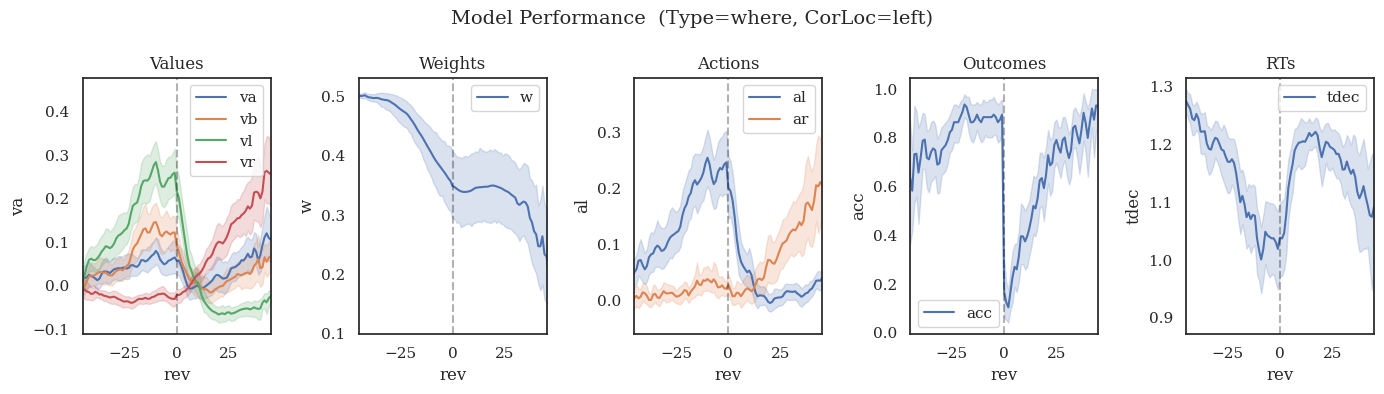

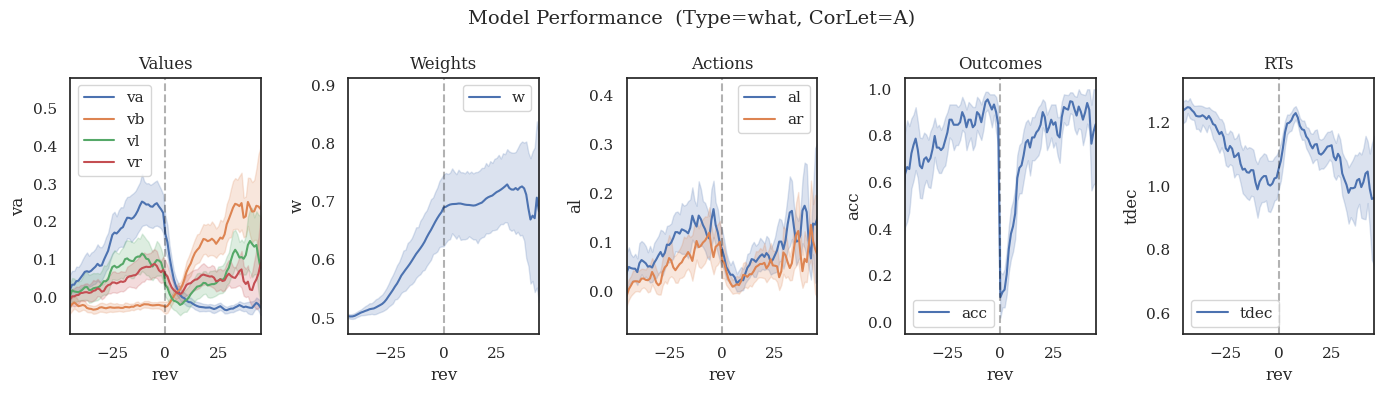

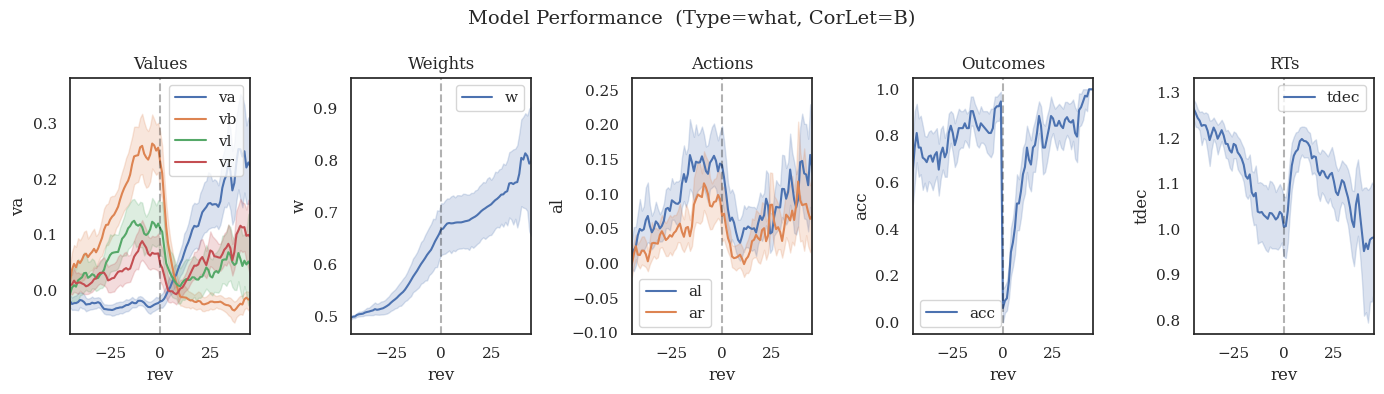

In [7]:
plot_performance(nef_data)
plot_values(nef_data, block_type='where', cor_loc='right', window_size=2)
plot_values(nef_data, block_type='where', cor_loc='left', window_size=2)
plot_values(nef_data, block_type='what', cor_let='A', window_size=2)
plot_values(nef_data, block_type='what', cor_let='B', window_size=2)

# Dynamics

In [12]:
df, sim, net = simulate('V', 0, 14, 80, 'random')

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80


[(70.0, 80.0)]

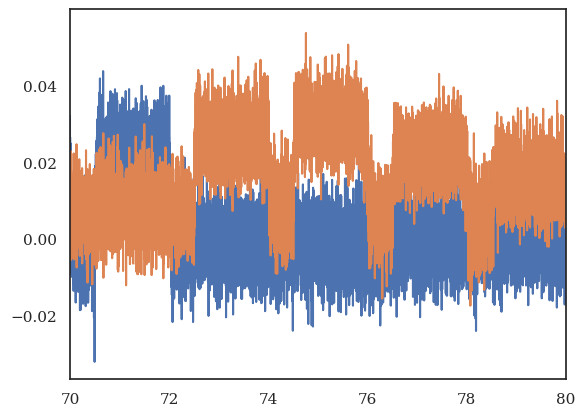

In [14]:
fig, ax = plt.subplots()
# ax.plot(sim.trange(), sim.data[net.p_v])
ax.plot(sim.trange(), sim.data[net.p_a])
# ax.plot(sim.trange(), sim.data[net.p_act])
ax.set(xlim=[70,80])